# Tutorial 6: Inspecting predicted proteome allocation

In this tutorial we will calculate the proteome allocation predicted by the _Bacillus subtilis_ ME-model.

## Import libraries

In [1]:
from coralme.builder.main import MEBuilder
from coralme.util.flux_analysis import flux_based_reactions
import coralme
import pandas
import tqdm

## Load

Load the ME-model coming out of the Troubleshooter

In [2]:
me = coralme.io.json.load_json_me_model("MEModel-step3-bsubtilis-TS.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16


Adding Metabolites into the ME-model...                                    : 100.0%|██████████|  4631/ 4631 [00:00<00:00]
Adding ProcessData into the ME-model...                                    : 100.0%|██████████|  4754/ 4754 [00:00<00:00]
Adding Reactions into the ME-model...                                      : 100.0%|██████████|  7759/ 7759 [00:16<00:00]
Updating ME-model Reactions...                                             : 100.0%|██████████|  6328/ 6328 [00:17<00:00]


## Solve

Set a high glucose uptake to see what proteome limitation looks like

In [3]:
me.reactions.EX_glc__D_e.bounds = (-10,0)

In [4]:
me.optimize()

The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Optimal
        4	0.5268855257634719	Not feasible
        5	0.4390712714695599	Optimal
        6	0.4829783986165159	Not feasible
        7	0.4610248350430379	Optimal
        8	0.4720016168297769	Not feasible
        9	0.4665132259364074	Not feasible
       10	0.4637690304897227	Not feasible
       11	0.4623969327663803	Optimal
       12	0.4630829816280515	Not feasible
       13	0.4627399571972159	Optimal
       14	0.4629114694126337	Optimal
       15	0.4629972255203426	Not feasible
       16	0.4629543474664882

True

## Proteome allocation

We here use some of the functions provided in coralME to calculate proteome allocation. This part of the analysis can take several minutes to run. The algorithm needs to traverse the ME-network finding where all proteins go (accounting for final destinations only) and calculate the partitioning from the fluxes.

### Calculate protein to complex partitioning

Here we calculate the final complexes to which 1 unit of every protein goes

In [5]:
from coralme.util.flux_analysis import get_partitioning,get_immediate_partitioning

In [6]:
ComplexPartitioning = {}
for protein in tqdm.tqdm(me.metabolites.query("^protein_")):
    if not isinstance(protein,coralme.core.component.TranslatedGene):
        continue
    partitioning = get_partitioning(protein,seen = set(),final_fraction=1.0)
    if not partitioning:
        continue
    ComplexPartitioning[protein.id] = {k.id:v for k,v in partitioning}

100%|██████████| 1350/1350 [06:33<00:00,  3.43it/s]


In [7]:
pandas.DataFrame.from_dict(ComplexPartitioning).fillna(0.).head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
BSU00090-MONOMER,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CPLX8J2-131,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00130-MONOMER,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00140-MONOMER,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00150-MONOMER,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate protein to function partitioning

Here we calculate the final reactions to which 1 unit of every protein goes

In [8]:
ReactionPartitioning = {}
for protein,partitioning in tqdm.tqdm(ComplexPartitioning.items()):
    ReactionPartitioning[protein] = {}
    tmp = pandas.Series()
    for k,fraction in partitioning.items():
        ip = {k.id:v for k,v in get_immediate_partitioning(me.get(k)).items()}
        tmp = tmp.append(pandas.Series(ip) * fraction)
        if tmp.duplicated().any():
            tmp = tmp.to_frame().reset_index().groupby("index").sum()[0]
    ReactionPartitioning[protein] = tmp.to_dict()

100%|██████████| 482/482 [06:26<00:00,  1.25it/s]


In [9]:
ReactionPartitioning = pandas.DataFrame.from_dict(ReactionPartitioning).fillna(0.)
ReactionPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
IMPD_FWD_BSU00090-MONOMER,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PYRIS_FWD_CPLX8J2-131,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCU,0.0,0.0,0.0,0.215596,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_30_AGC,0.0,0.0,0.0,0.192273,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCA,0.0,0.0,0.0,0.149363,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get protein translation fluxes

In [10]:
dct = {}
for r in me.query("translation_"):
    p = "protein_" + r.id.split("translation_")[1]
    dct[p] = r.flux * me.get(p).formula_weight/1000
TranslationFluxes = pandas.Series(dct)
TranslationFluxes.head()

protein_BSU00090    1.860233e-05
protein_BSU00110    1.493829e-09
protein_BSU00120    1.017531e-09
protein_BSU00130    2.353139e-05
protein_BSU00140    4.108362e-08
dtype: float64

### Combine results into one dataframe

Now we calculate the contributions of all proteins to every reaction flux

In [11]:
FluxPartitioning = (ReactionPartitioning*TranslationFluxes).dropna(axis=1)
FluxPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
IMPD_FWD_BSU00090-MONOMER,0.000019,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PYRIS_FWD_CPLX8J2-131,0.000000,1.493829e-09,1.017531e-09,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCU,0.000000,0.000000e+00,0.000000e+00,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_30_AGC,0.000000,0.000000e+00,0.000000e+00,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCA,0.000000,0.000000e+00,0.000000e+00,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The sum of all fluxes should add up to the protein biomass

In [12]:
FluxPartitioning.sum().sum()

0.15188169695370568

In [13]:
me.solution.fluxes["protein_biomass_to_biomass"]

0.1518843089390093

### Get reaction to class dictionary

Here we classify all reactions into categories to simplify the analysis

In [14]:
def get_function(r,metabolics=False):
    if isinstance(r,coralme.core.reaction.MetabolicReaction) and hasattr(r,'subsystem'):
        if r.subsystem and metabolics:
            return 'Metabolic:' + r.subsystem
        return 'Metabolic'
    if isinstance(r,coralme.core.reaction.TranslationReaction):
        return 'Translation'
    elif isinstance(r,coralme.core.reaction.TranscriptionReaction):
        return 'Transcription'
    elif isinstance(r,coralme.core.reaction.tRNAChargingReaction):
        return 'tRNA-Charging'
    elif isinstance(r,coralme.core.reaction.PostTranslationReaction):
        return 'Post-translation'
    elif isinstance(r,coralme.core.reaction.SummaryVariable):
        return 'Biomass'
    return "No_function"

In [15]:
ReactionToClass = pandas.DataFrame(index=[r.id for r in me.reactions]).reset_index()
ReactionToClass["Function1"] = ReactionToClass["index"].apply(lambda x:get_function(me.get(x)))
ReactionToClass["Function2"] = ReactionToClass["index"].apply(lambda x:get_function(me.get(x),metabolics=True))
ReactionToClass = ReactionToClass.set_index("index").sort_index()
ReactionToClass.head()

,Function1,Function2
index,,
23CN2P1_FWD_BSU07840-MONOMER,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
23CN2P1_REV_BSU07840-MONOMER,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
23CN2P2_FWD_BSU07840-MONOMER,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
23CN2P2_REV_BSU07840-MONOMER,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
23CN2P3_FWD_BSU07840-MONOMER,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids


### Visualize proteome allocation

Now we annotate it for further analysis

In [16]:
AnnotatedFluxPartitioning = pandas.concat([FluxPartitioning,ReactionToClass],axis=1).dropna(axis=0)
AnnotatedFluxPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy,Function1,Function2
IMPD_FWD_BSU00090-MONOMER,0.000019,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
PYRIS_FWD_CPLX8J2-131,0.000000,1.493829e-09,1.017531e-09,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic:S_Coenzymes_and_prosthetic_groups
charging_tRNA_BSU_tRNA_63_UCU,0.000000,0.000000e+00,0.000000e+00,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging
charging_tRNA_BSU_tRNA_30_AGC,0.000000,0.000000e+00,0.000000e+00,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging
charging_tRNA_BSU_tRNA_63_UCA,0.000000,0.000000e+00,0.000000e+00,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging


<Axes: >

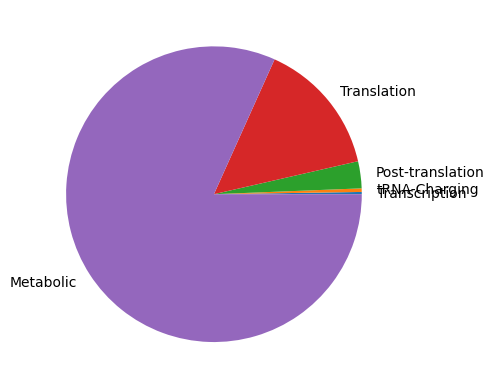

In [17]:
AnnotatedFluxPartitioning.groupby("Function1").sum().sum(axis=1).sort_values().plot.pie()

<Axes: >

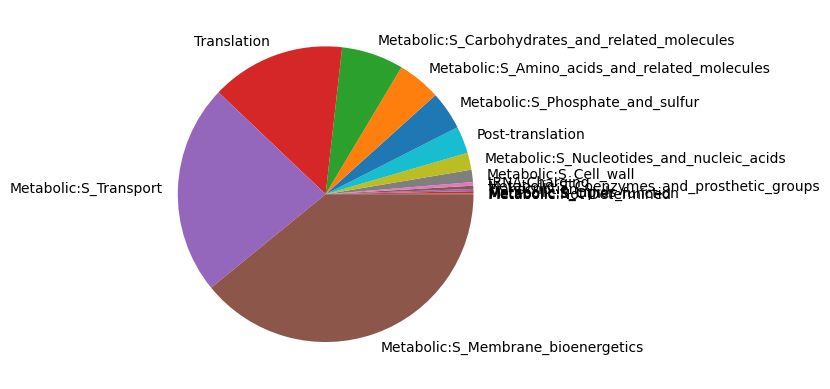

In [18]:
AnnotatedFluxPartitioning.groupby("Function2").sum().sum(axis=1).sort_values().plot.pie()